In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from rich.progress import track
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os

In [54]:
img_scale = 2

# import data and create trainloader
class Cropper:
    def __call__(self, img):
        return transforms.functional.crop(img, 35, 54, 218, 336)


# import data and create trainloader
train_dataset = datasets.ImageFolder(
    "data/train",
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            Cropper(),
            transforms.Resize((218 // img_scale, 336 // img_scale)),
            transforms.ToTensor(),
        ]
    ),
)
test_dataset = datasets.ImageFolder(
    "data/test",
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            Cropper(),
            transforms.Resize((218 // img_scale, 336 // img_scale)),
            transforms.ToTensor(),
        ]
    ),
)

train_data = torch.stack([train_dataset[i][0] for i in range(2,3)])
train_labels = torch.Tensor([train_dataset[i][1] for i in range(len(train_dataset))])

# plot transformed spectrograms
# plt.imshow(np.squeeze(train_data[0]))
# plt.show()
# exit()

test_data = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.Tensor([test_dataset[i][1] for i in range(len(test_dataset))])


# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(3960, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1).clone()
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))
model.eval();

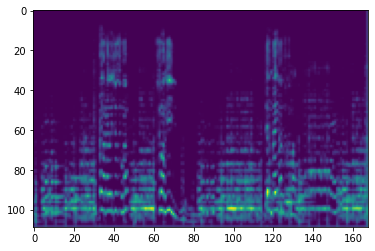

In [55]:
# select one image in training dataset
occ_img = train_data
fig = plt.figure(facecolor="white")
plt.imshow(np.squeeze(train_data[0]))
plt.show()

In [56]:
rows = train_data.shape[2]
cols = train_data.shape[3]
all_outputs = []
all_diffs = []
# calculate output for original image
original_output = model(train_data).detach().numpy()

# calculate outputs for occluded images
for row in range(rows):
    for col in range(cols):
        occ_img = train_data.clone()
        occ_img[0][0][row][col] = 0
        tmp_out = model(occ_img)
        all_outputs.append(tmp_out.detach().numpy())

# now calculate differences
for output in all_outputs:
    all_diffs.append(np.square(np.linalg.norm(original_output-output)))

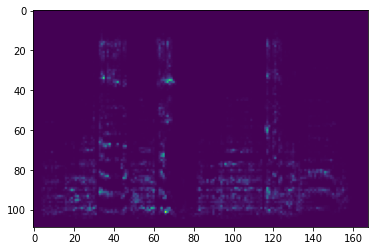

In [59]:
# now reshape and display masked spectrogram
all_diffs = np.array(all_diffs)
mask = all_diffs.reshape(rows,cols)
fig = plt.figure(facecolor="white")
plt.imshow(mask)
# plt.imshow(np.multiply(mask, np.squeeze(train_data.detach().numpy())))
plt.show()